[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MAROON-LABKOM/script-praktikum/blob/master/pemrograman-data-analisis/segmentasi-kmeans.ipynb)

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

from yellowbrick.cluster import silhouette_visualizer
from yellowbrick.cluster.elbow import kelbow_visualizer

In [18]:
df_orders = pd.read_excel("northwind_db.xlsx", sheet_name="orders")
df_orders_details = pd.read_excel("northwind_db.xlsx", sheet_name="order_details")
df_products = pd.read_excel("northwind_db.xlsx", sheet_name="products")
df_customers = pd.read_excel("northwind_db.xlsx", sheet_name="customers")

In [19]:
df_RFM = df_customers.merge(df_orders, left_on="customer_id", right_on="customer_id", how="inner")
df_RFM = df_RFM.merge(df_orders_details, left_on="order_id", right_on="order_id", how="inner")
df_RFM["order_date"] = pd.to_datetime(df_RFM["order_date"])

In [20]:
df_RFM.head()

,customer_id,company_name,contact_name,contact_title,address,city,region,postal_code,country,phone,...,ship_name,ship_address,ship_city,ship_region,ship_postal_code,ship_country,product_id,unit_price,quantity,discount
0,ALFKI,Alfreds Futterkiste,Maria Anders,Sales Representative,Obere Str. 57,Berlin,NaN,12209,Germany,030-0074321,...,Alfreds Futterkiste,Obere Str. 57,Berlin,NaN,12209,Germany,28,456,15,25
1,ALFKI,Alfreds Futterkiste,Maria Anders,Sales Representative,Obere Str. 57,Berlin,NaN,12209,Germany,030-0074321,...,Alfreds Futterkiste,Obere Str. 57,Berlin,NaN,12209,Germany,39,18,21,25
2,ALFKI,Alfreds Futterkiste,Maria Anders,Sales Representative,Obere Str. 57,Berlin,NaN,12209,Germany,030-0074321,...,Alfreds Futterkiste,Obere Str. 57,Berlin,NaN,12209,Germany,46,12,2,25
3,ALFKI,Alfreds Futterkiste,Maria Anders,Sales Representative,Obere Str. 57,Berlin,NaN,12209,Germany,030-0074321,...,Alfred's Futterkiste,Obere Str. 57,Berlin,NaN,12209,Germany,63,439,20,0
4,ALFKI,Alfreds Futterkiste,Maria Anders,Sales Representative,Obere Str. 57,Berlin,NaN,12209,Germany,030-0074321,...,Alfred's Futterkiste,Obere Str. 57,Berlin,NaN,12209,Germany,3,10,6,0


## Segmentasi RFM

Setelah didapatkan tabel dengan semua informasi yang dibutuhkan,

 - banyaknya `customer_id` yang unik akan menjadi **frequency**
 - selisih tanggal antara `order_date` dan tanggal analisis akan menjadi **recency**
 - `unit_price`, `quantity`, dan `discount` akan menjadi faktor **monetary**

 Selanjutnya hitung komponen RFM menggunakan fungsi apply dengan melakukan agregasi pada kolom-kolom di atas.

In [21]:
# Recency
# Ambil selisih waktu antara waktu order (order_date) dan waktu referensi (1999-01-01)

df_features = pd.DataFrame(df_RFM.groupby("customer_id")["order_date"].max()).reset_index()
df_features["recency"] = df_features.apply(lambda x: pd.to_datetime("1999-01-01") - x["order_date"], axis=1)
df_features["recency"] = df_features["recency"].dt.days

df_features = df_features.drop("order_date", axis=1)

In [22]:
# Frequency
# Hitung banyaknya transaksi yang dilakukan oleh seseorang

df_temp_freq = pd.DataFrame(df_RFM.groupby("customer_id")["order_date"].count())
df_temp_freq = df_temp_freq.rename(columns={"order_date": "frequency"})
df_temp_freq = df_temp_freq.reset_index()

df_features = df_features.merge(df_temp_freq, on="customer_id")

In [23]:
# Monetary
# Hitung total pembelian pada suatu order
# (unit_price * quantity) - (unit_price * quantity * discount / 100.0)

df_temp_monetary = df_RFM.copy()
#df_temp_monetary["monetary_temp"] = (df_temp_monetary["unit_price"] * df_temp_monetary["quantity"]) - (df_temp_monetary["unit_price"] * df_temp_monetary["quantity"] * df_temp_monetary["discount"] / 100.0)
df_temp_monetary["monetary_temp"] = df_temp_monetary["unit_price"] * df_temp_monetary["quantity"]

df_temp_monetary2 = pd.DataFrame(df_temp_monetary.groupby("customer_id")["monetary_temp"].sum())
df_temp_monetary2 = df_temp_monetary2.rename(columns={"monetary_temp": "monetary"})
df_temp_monetary2 = df_temp_monetary2.reset_index()

df_features = df_features.merge(df_temp_monetary2, on="customer_id")

In [24]:
df_features.head()

,customer_id,recency,frequency,monetary
0,ALFKI,267,12,75815
1,ANATR,303,10,12279
2,ANTON,338,17,156617
3,AROUT,266,30,107555
4,BERGS,303,52,611515


Setelah mendapatkan tiga komponen RFM, selanjutnya bisa dibuat box plot untuk menunjukkan empat kuartil pada data yang akan digunakan untuk melakukan segmentasi menggunakan kuartil.

In [25]:
fig = make_subplots(rows=1, cols=3, subplot_titles=("Recency", "Frequency", "Monetary"))

fig.add_trace(go.Box(y=df_features["recency"], boxpoints="all"), row=1, col=1)
fig.add_trace(go.Box(y=df_features["frequency"], boxpoints="all"), row=1, col=2)
fig.add_trace(go.Box(y=df_features["monetary"], boxpoints="all"), row=1, col=3)

fig.update_layout(showlegend=False)
fig.show()

In [26]:
df_features.describe()

,recency,frequency,monetary
count,89.000000,89.000000,8.900000e+01
mean,291.561798,24.213483,2.709896e+05
std,87.484278,19.793520,4.871066e+05
min,240.000000,2.000000,2.880000e+02
25%,248.000000,11.000000,3.548800e+04
50%,263.000000,20.000000,9.998800e+04
75%,298.000000,31.000000,2.930500e+05
max,897.000000,116.000000,2.646773e+06


## Clustering K-Means

Pada pembahasan sebelumnya digunakan metode segmentasi menggunakan kuartil, pada pembahasan ini akan dilakukan clustering menggunakan metode K-means.

Sebelum mulai melakukan proses clustering, pertama kita akan ambil kolom 2-3 yang berisi komponen RFM.

In [27]:
X_train = df_features.iloc[:, 1:4].values
X_train.shape

(89, 3)

Selanjutnya akan dilakukan proses scaling untuk mengatasi range yang jauh pada titik-titik data. Proses scaling yang digunakan adalah Min-Max scaling, proses ini melakukan scaling untuk mengubah range data menjadi antara 0 dan 1.

In [28]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_train)

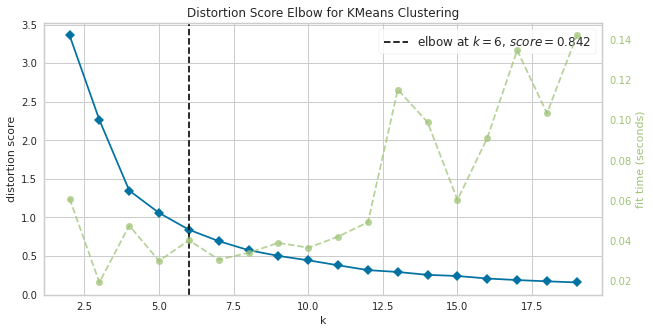

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [29]:
# Elbow method
plt.figure(figsize=(10,5))
kelbow_visualizer(KMeans(random_state=4), X_scaled, k=(2, 20)).show()

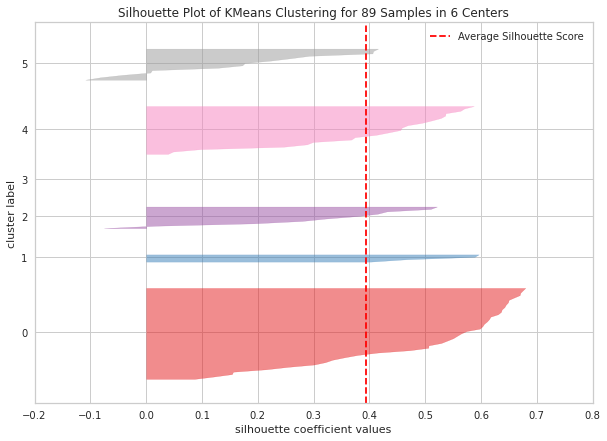

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 89 Samples in 6 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [30]:
# Silhouette analysis
plt.figure(figsize=(10,7))
silhouette_visualizer(KMeans(n_clusters=6, random_state=42), X_scaled).show()

In [31]:
model = KMeans(n_clusters=6, random_state=42)
model.fit(X_scaled)

clusters_array = np.hstack((X_scaled, model.labels_.reshape(-1, 1)))
seg_kmeans = pd.DataFrame(clusters_array, columns=["R_score", "F_score", "M_score", "cluster"])
px.scatter_3d(seg_kmeans, x="R_score", y="F_score", z="M_score", color="cluster")